In [1]:
import pandas as pd
import numpy as np
import nltk
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from bs4 import BeautifulSoup  
import re
from nltk.corpus import stopwords 

In [2]:
def label_data():
    rows = pd.read_csv('Amazon_Unlocked_Mobile.csv', header=0, index_col=False, delimiter=',')
    labels = []
    for cell in rows['Rating']:
        if cell >= 4:
            labels.append('2')   #Good
        elif cell == 3:
            labels.append('1')   #Neutral
        else:
            labels.append('0')   #Poor
            
    rows['Label'] = labels
    del rows['Review Votes']
    return rows

In [3]:
def clean_data(data):
   
    #replace blank values in all the cells with 'nan'
    data.replace('',np.nan,inplace=True)
    #delete all the rows which contain at least one cell with nan value
    data.dropna(axis=0, how='any', inplace=True)
    

    #save output csv file
    data.to_csv('labelled_dataset.csv', index=False)
    return data

In [4]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [5]:
def modelEvaluation(predictions, y_test_set):
    #Print model evaluation to predicted result 
    
    print "\nAccuracy on validation set: {:.16f}".format(accuracy_score(y_test_set, predictions))
    print "Fscore = " + str(metrics.precision_recall_fscore_support(y_test_set, predictions, pos_label=2, average='weighted'))
    print "F-1 score = " + str(metrics.f1_score(y_test_set, predictions, pos_label=2, average='weighted'))
    print "confusion matrix = " + str(metrics.confusion_matrix(y_test_set, predictions))
    print "\nClassification report : \n", metrics.classification_report(y_test_set, predictions)

In [6]:
if __name__ == '__main__':
    data = label_data()
    data = clean_data(data)


In [7]:
    #prints first 5 rows of the dataset
    data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,2
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",2
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,2
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,2
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,2


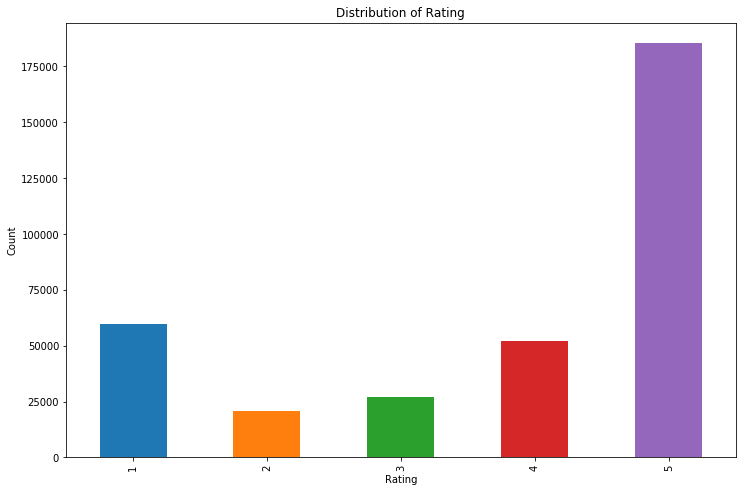

In [8]:
    # Plot distribution of rating
    plt.figure(figsize=(12,8))
    data['Rating'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Rating')
    plt.xlabel('Rating')
    plt.ylabel('Count')

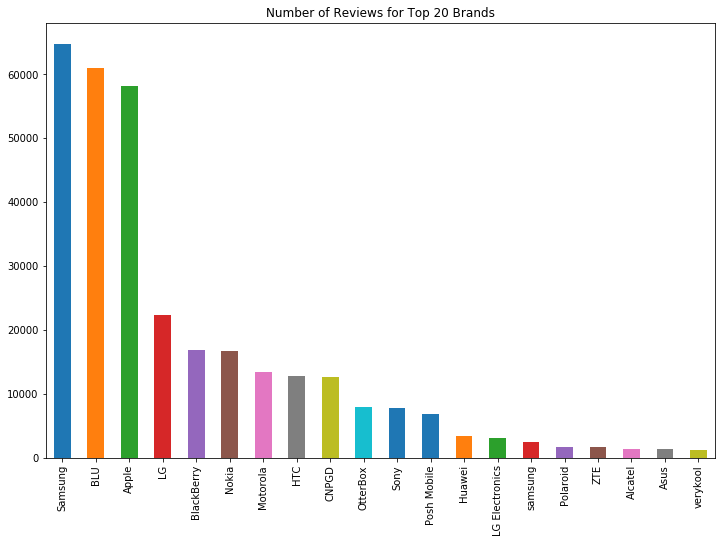

In [9]:
    # Plot number of reviews for top 20 brands
    brands = data["Brand Name"].value_counts()
    # brands.count()
    plt.figure(figsize=(12,8))
    brands[:20].plot(kind='bar')
    plt.title("Number of Reviews for Top 20 Brands")

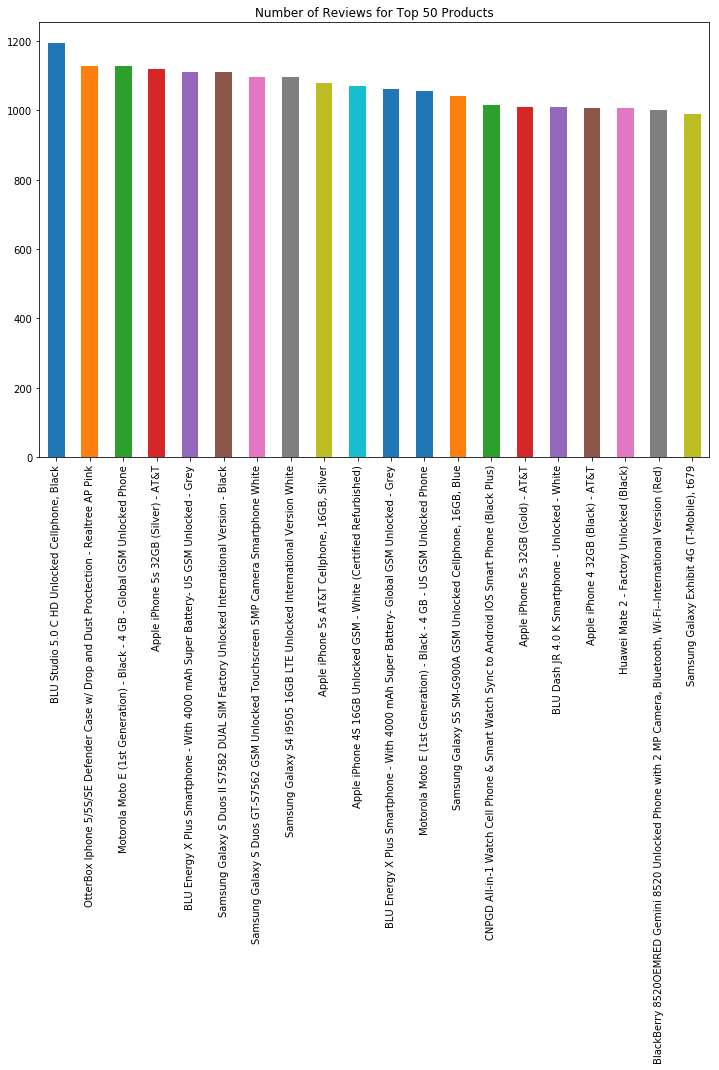

In [10]:
    # Plot number of reviews for top 50 products
    products = data["Product Name"].value_counts()
    plt.figure(figsize=(12,8))
    products[:20].plot(kind='bar')
    plt.title("Number of Reviews for Top 50 Products")

In [11]:
    #split data into training and testing set
    x_train, x_test, y_train, y_test = train_test_split(data['Reviews'], data['Label'], test_size=0.1, random_state=0)

In [12]:
    # Preprocess text data in training set and validation set
    x_train_cleaned = []
    x_test_cleaned = []

    for d in x_train:
        x_train_cleaned.append(cleanText(d))

    for d in x_test:
        x_test_cleaned.append(cleanText(d))    

C:\Anaconda2\lib\site-packages\bs4\__init__.py:207: UserWarning: "http://www.amazon.com/gp/product/B00OSTKZWM?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
C:\Anaconda2\lib\site-packages\bs4\__init__.py:207: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that d

In [13]:
    # Fit and transform the training data to a document-term matrix using CountVectorizer
    countVect = CountVectorizer() 
    x_train_countVect = countVect.fit_transform(x_train_cleaned)
    print "Number of features : %d \n" %len(countVect.get_feature_names()) #6378 
    print "Show feature names : \n", countVect.get_feature_names()

Number of features : 54166 

Show feature names : 
[u'aa', u'aaa', u'aaaa', u'aaaaa', u'aaaaaa', u'aaaaaaaa', u'aaaaaaaaa', u'aaaaaaaaaaa', u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc', u'aaaaaaamazing', u'aaaaaand', u'aaaaargh', u'aaaalll', u'aaaannndd', u'aaargh', u'aaarrrgghhhh', u'aab', u'aac', u'aactivate', u'aae', u'aag', u'aagain', u'aah', u'aahs', u'aalus', u'aamazon', u'aand', u'aandd', u'aandns', u'aandve', u'aaps', u'aare', u'aaron', u'aarp', u'aarse', u'aat'

In [14]:
    # Train MultinomialNB classifier
    mnb = MultinomialNB()
    mnb.fit(x_train_countVect, y_train)
    # Evaluate the model on validaton set
    predictions = mnb.predict(countVect.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set: 0.8552436794287539
Fscore = (0.8408993162603613, 0.8552436794287539, 0.84584777054479088, None)
F-1 score = 0.845847770545


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1045: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


confusion matrix = [[ 6594   370  1174]
 [  770   724  1242]
 [  923   508 22146]]

Classification report : 
             precision    recall  f1-score   support

          0       0.80      0.81      0.80      8138
          1       0.45      0.26      0.33      2736
          2       0.90      0.94      0.92     23577

avg / total       0.84      0.86      0.85     34451



In [15]:
    # Fit and transform the training data to a document-term matrix using TfidfVectorizer 
    tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
    x_train_tfidf = tfidf.fit_transform(x_train)
    print "Number of features : %d \n" %len(tfidf.get_feature_names()) #1722
    print "Show some feature names : \n", tfidf.get_feature_names()

Number of features : 21131 

Show some feature names : 
[u'00', u'000', u'0000', u'000000', u'000mah', u'007', u'00am', u'00pm', u'01', u'011', u'02', u'03', u'032g', u'04', u'04th', u'05', u'051', u'06', u'07', u'08', u'09', u'0a', u'0c', u'0ghz', u'0hd', u'0ii', u'0inch', u'0k', u'0l', u'0mp', u'0s', u'0stars', u'0\xe7', u'10', u'100', u'1000', u'10000', u'100000', u'1000000', u'1000mah', u'1001multi', u'100gb', u'100hours', u'100mb', u'100min', u'100s', u'100x', u'101', u'1016', u'102', u'1020', u'103', u'104', u'105', u'106', u'107', u'108', u'1080', u'1080hd', u'1080i', u'1080p', u'1080x1920', u'109', u'10am', u'10gb', u'10hrs', u'10i', u'10k', u'10mbps', u'10min', u'10mins', u'10pm', u'10screen', u'10so', u'10th', u'10x', u'10year', u'10yo', u'11', u'110', u'11059mem', u'1109miami', u'110v', u'111', u'1116', u'112', u'1122', u'113', u'1136', u'114', u'115', u'115mmoverall', u'118', u'119', u'119gb', u'119mbps', u'11ac', u'11gb', u'11pm', u'11th', u'11yr', u'12', u'120', u'1200', 

In [16]:
    # Logistic Regression
    lr = LogisticRegression()
    lr.fit(x_train_tfidf, y_train)
    # Evaluate on the validaton set
    predictions = lr.predict(tfidf.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set: 0.8812516327537662
Fscore = (0.86725991209856501, 0.88125163275376617, 0.86188814807322855, None)
F-1 score = 0.861888148073
confusion matrix = [[ 7123   104   911]
 [  896   448  1392]
 [  651   137 22789]]

Classification report : 
             precision    recall  f1-score   support

          0       0.82      0.88      0.85      8138
          1       0.65      0.16      0.26      2736
          2       0.91      0.97      0.94     23577

avg / total       0.87      0.88      0.86     34451



In [17]:
    #x_train_subset = tfidf.transform(x_train_cleaned[:100])
    x_train_input = tfidf.transform(x_train_cleaned)
    svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
    svr_lin.fit(x_train_input, y_train)
    y_svr_lin_predicted = svr_lin.predict(tfidf.transform(x_test_cleaned))

In [18]:
    modelEvaluation(y_svr_lin_predicted, y_test)


Accuracy on validation set: 0.8917012568575658
Fscore = (0.88340809851604707, 0.89170125685756585, 0.87727690551266624, None)
F-1 score = 0.877276905513
confusion matrix = [[ 7219   114   805]
 [  848   676  1212]
 [  622   130 22825]]

Classification report : 
             precision    recall  f1-score   support

          0       0.83      0.89      0.86      8138
          1       0.73      0.25      0.37      2736
          2       0.92      0.97      0.94     23577

avg / total       0.88      0.89      0.88     34451



In [19]:
    decTree = DecisionTreeClassifier()
    decTree.fit(x_train_input, y_train)
    y_decTree_predicted = decTree.predict(tfidf.transform(x_test_cleaned))

In [20]:
    modelEvaluation(y_decTree_predicted, y_test)


Accuracy on validation set: 0.9268236045397812
Fscore = (0.92533429544805723, 0.92682360453978119, 0.92586947237393169, None)
F-1 score = 0.925869472374
confusion matrix = [[ 7281   251   606]
 [  300  1904   532]
 [  540   292 22745]]

Classification report : 
             precision    recall  f1-score   support

          0       0.90      0.89      0.90      8138
          1       0.78      0.70      0.73      2736
          2       0.95      0.96      0.96     23577

avg / total       0.93      0.93      0.93     34451



In [21]:
    rand = RandomForestClassifier(n_estimators=80)
    rand.fit(x_train_input, y_train)
    y_rand_predicted = rand.predict(tfidf.transform(x_test_cleaned))

In [22]:
    modelEvaluation(y_rand_predicted, y_test)


Accuracy on validation set: 0.9494354300310586
Fscore = (0.95028682839852208, 0.94943543003105857, 0.94692395904851079, None)
F-1 score = 0.946923959049
confusion matrix = [[ 7561    12   565]
 [  270  1788   678]
 [  197    20 23360]]

Classification report : 
             precision    recall  f1-score   support

          0       0.94      0.93      0.94      8138
          1       0.98      0.65      0.78      2736
          2       0.95      0.99      0.97     23577

avg / total       0.95      0.95      0.95     34451



In [23]:
data = pd.read_csv('labelled_dataset.csv', encoding='utf-8', header=0, index_col=False, delimiter=',')
recommend = {}

budget = int(raw_input("Enter your budget: "))
for index, row in data.iterrows():
    if row["Price"] < budget and row["Label"] == 2:
        if recommend.has_key(row["Product Name"]):
            recommend[row["Product Name"]]["count"] += 1
        else:
            temp = {}
            temp["Brand"] = row["Brand Name"]
            temp["count"] = 1
            recommend[row["Product Name"]] = temp

count_set = []

for item in recommend.items():
    #print item[1]
    count_set.append([item[0], item[1]["count"], item[1]["Brand"]])

filtered = pd.DataFrame(count_set, columns=["Product Name", "count", "Brand Name"])
filtered.head()

filtered.sort_values(by="count",ascending=False, inplace=True)
filtered.head()

Enter your budget: 350


,Product Name,count,Brand Name
553,Motorola Moto E (1st Generation) - Black - 4 G...,984,Motorola
176,"BLU Studio 5.0 C HD Unlocked Cellphone, Black",962,BLU
2779,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,927,Samsung
2327,Motorola Moto E (1st Generation) - Black - 4 G...,918,Motorola
2645,Huawei Mate 2 - Factory Unlocked (Black),882,Huawei
